In [22]:
# Real life data

import logging
import threading
import itertools
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import ibm_db
import shap

from pandas_profiling import ProfileReport
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions.db import Database
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.enginelog import EngineLogging
from iotfunctions.dbtables import FileModelStore
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from iotfunctions.dbtables import FileModelStore, DBModelStore
from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore, GBMRegressor, SimpleRegressor)
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import MinCovDet
from sklearn import metrics
import scipy as sp
import scipy.fftpack
import skimage as ski  
from skimage import util as skiutil # for nifty windowing
import pyod as pyod
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

2020-06-04T09:54:23.387 DEBUG matplotlib.pyplot.switch_backend Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [23]:
credentials={"_id":"2d6dbddcd0ef52f54ab7e7a81f4face6","tenantId":"Monitor-Demo",             
             "db2":{"username":"bluadmin","password":"MjZkZTEwN2FjMWY1","databaseName":"BLUDB",                    
                    "port":50000,"httpsUrl":"https://dashdb-enterprise-yp-dal12-125.services.dal.bluemix.net:8443",
                    "host":"dashdb-enterprise-yp-dal12-125.services.dal.bluemix.net"},
             "iotp":{"url":"https://vrvzh6.internetofthings.ibmcloud.com/api/v0002","orgId":"vrvzh6",
                     "host":"vrvzh6.messaging.internetofthings.ibmcloud.com","port":8883,
                     "asHost":"api-beta.connectedproducts.internetofthings.ibmcloud.com",
                     "apiKey":"a-vrvzh6-am4fwylysp","apiToken":"F+PF@HQhe_N*ecS4gb"},
             "messageHub":{"brokers":["kafka03-prod02.messagehub.services.us-south.bluemix.net:9093",
                                      "kafka01-prod02.messagehub.services.us-south.bluemix.net:9093",
                                      "kafka05-prod02.messagehub.services.us-south.bluemix.net:9093",
                                      "kafka02-prod02.messagehub.services.us-south.bluemix.net:9093",
                                      "kafka04-prod02.messagehub.services.us-south.bluemix.net:9093"],
                           "username":"S0Zzzp1zZsF4hotd","password":"S1wyAP2jy9R2cmqcZwSfoqL5gByWSqn9"},
             "objectStorage":{"region":"global","username":"5c9b5139a83d4f68bd2fe458a2117fac",
                              "password":"5b282a68b84d070bd8674da4771998c6cb0743a4a0288129"},
             "config":{"objectStorageEndpoint":"https://undefined",
                       "bos_logs_bucket":"analytics-logs-monitor-demo-9c6aaaf268a1",
                       "bos_runtime_bucket":"analytics-runtime-monitor-demo-395729cb6a06",
                       "mh_topic_analytics_alerts":"analytics-alerts-Monitor-Demo"}}
credentials['db2'] = {"username":"bluadmin","password":"NjYxYzIwODRkMjAx","databaseName":"BLUDB",
                      "port":50000,"httpsUrl":"https://dashdb-enterprise-yp-dal12-134.services.dal.bluemix.net:8443",
                      "host":"dashdb-enterprise-yp-dal12-134.services.dal.bluemix.net"}
db_schema=None
fm = FileModelStore()
db = Database(credentials=credentials, model_store=fm)
print (db)

2020-06-04T09:54:24.221 INFO iotfunctions.dbtables.__init__ Init FileModelStore
2020-06-04T09:54:24.222 INFO iotfunctions.db.__init__ Connection string for SqlAlchemy => db2): db2+ibm_db://bluadmin:NjYxYzIwODRkMjAx@dashdb-enterprise-yp-dal12-134.services.dal.bluemix.net:50000/BLUDB;


In [24]:
#con = db.connection.connect()
DB2ConnString = 'DATABASE=' + credentials['db2']['databaseName'] + \
                ';HOSTNAME=' + credentials['db2']['host'] + \
                ';PORT=' + str(credentials['db2']['port']) + \
                ';PROTOCOL=TCPIP;UID=' + credentials['db2']['username'] + \
                ';PWD=' + credentials['db2']['password']
            
db_connection = ibm_db.connect(DB2ConnString, '', '')


# db.model = DBModelStore(credentials['tenantId'], None, credentials['db2']['username'], db.connection.connect(), 'db2'  )

In [25]:
model_store = DBModelStore(credentials['tenantId'], "TESTENTITYID", credentials['db2']['username'], db_connection, 'db2')
db.model_store = model_store

In [26]:
# need a helper function to convert array columns to something easier
from scipy import linalg
def l2norm(df, tcol, col1, col2 = None, col3 = None):
    def str_norm(cols_str):
        '''norm for one string element (encodes an array of value)
           in one column of a data point'''
        return linalg.norm(np.fromstring(cols_str.replace('[',' ').replace(']','').replace('\"', ''), sep = ','))**2

    def column_norm(df, tcol, col1, col2=None, col3=None):
        '''norm of all columns specified in parameters for all datapoints'''
        df_temp = pd.DataFrame()
        df_temp['col1_np'] = df[col1].apply(str_norm)
        df_temp['col2_np'] = 0 
        df_temp['col3_np'] = 0
        if col2 is not None:
            df_temp['col2_np'] = df[col2].apply(str_norm)
        if col3 is not None:
            df_temp['col3_np'] = df[col3].apply(str_norm)

        return (df_temp['col1_np'] + df_temp['col2_np'] + df_temp['col3_np'])**(1/2)
    
    df[tcol] = column_norm(df, tcol, col1, col2, col3)

def unrollAccel(df):
    l0,l1,l2,l3,l4=[],[],[],[],[]
    for i in df['ACCEL_POWER'].values:
        l0.append(eval(eval(i)[0]))
        l1.append(eval(eval(i)[1]))
        l2.append(eval(eval(i)[2]))
        l3.append(eval(eval(i)[3]))
        l4.append(eval(eval(i)[4]))
    df['accel_power_0'] = np.asarray(l0)
    df['accel_power_1'] = np.asarray(l1)
    df['accel_power_2'] = np.asarray(l2)
    df['accel_power_3'] = np.asarray(l3)
    df['accel_power_4'] = np.asarray(l4)
    
listAttr = ['timestamp','entity','vibrations','rms','accel_speed','accel_power_0','accel_power_1',
            'accel_power_2','accel_power_3','accel_power_4']

In [27]:
# Now we proceed to customer data - GOOD CASE

# Get stuff in
df_input_raw = pd.read_csv('./Armstark04714B6046D5.csv', index_col=False, parse_dates=['RCV_TIMESTAMP_UTC'])
df_input_raw['entity']=df_input_raw['DEVICE_ID']
df_input_raw['timestamp']=df_input_raw['RCV_TIMESTAMP_UTC']

# and sort it by timestamp
df_input_raw = df_input_raw.sort_values(by='timestamp')
df_input_raw = df_input_raw.set_index(['entity','timestamp']).dropna()

l2norm(df_input_raw, 'vibrations', 'VIBRATIONS_XAXIS', 'VIBRATIONS_YAXIS', 'VIBRATIONS_ZAXIS')
l2norm(df_input_raw, 'rms', 'RMS_X', 'RMS_Y', 'RMS_Z')
l2norm(df_input_raw, 'accel_speed', 'ACCEL_SPEED')
unrollAccel(df_input_raw)
#l2norm(df_input_raw, 'accel_power', 'ACCEL_POWER')

df_input = df_input_raw.filter(listAttr, axis=1)
df_input_raw.describe()

,vibrations,rms,accel_speed,accel_power_0,accel_power_1,accel_power_2,accel_power_3,accel_power_4
count,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000,8620.000000
mean,3.759047,2.170460,2208.854495,2.453523,2.453312,2.452808,2.452053,2.452439
std,0.033272,0.002922,589.925540,0.856247,0.857594,0.857678,0.857200,0.856340
min,3.616515,2.155864,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.737696,2.169444,2316.566425,2.251800,2.251800,2.252000,2.252000,2.251800
50%,3.757949,2.170800,2318.802493,2.313800,2.313400,2.311800,2.312200,2.312600
75%,3.780154,2.171949,2379.176328,2.691450,2.692100,2.685100,2.681850,2.682300
max,3.898555,2.184292,2672.101233,5.325799,5.293200,5.334001,5.278600,5.282000


#### Pandas Profiling

Try Pandas Profiling to get an overview about the data, mostly its distributions and correlations
<br>


In [28]:
# profile = ProfileReport(df_input, title='Pandas Profiling Report', html={'style':{'full_width':True}})
# profile.to_widgets()

In [29]:
df_input2 = df_input.copy()

Indexlist = df_input2.index.to_list()
Indexlist_new = []
for p in Indexlist:
    p_new = ('testentity', p[1])
    Indexlist_new.append(p_new)
df_input2.index = Indexlist_new
df_input = pd.concat([df_input,df_input2])
df_input

vibrations       rms  accel_speed  \
entity       timestamp                                                    
04714B6046D5 2020-01-01 00:02:25.928    3.787826  2.171877  2316.566425   
             2020-01-01 00:07:26.074    3.776503  2.170646  2316.566425   
             2020-01-01 00:12:25.663    3.715573  2.171475  2316.566425   
             2020-01-01 00:17:26.020    3.765538  2.171679  2316.566425   
             2020-01-01 00:22:25.727    3.725934  2.170599  2316.566425   
...                                          ...       ...          ...   
testentity   2020-01-31 11:39:23.476    3.725156  2.171589  2318.802493   
             2020-01-31 11:44:23.497    3.766786  2.170778  2318.802493   
             2020-01-31 11:49:23.443    3.737750  2.171533  2318.802493   
             2020-01-31 11:54:23.499    3.771797  2.172369  2318.802493   
             2020-01-31 11:59:23.501    3.758436  2.171821  2318.802493   

                                      accel_power_0  accel_power_1  \
entity       timestamp                                               
04714B6046D5 2020-01-01 00:02:25.928         2.2904         2.2824   
             2020-01-01 00:07:26.074         2.2822         2.2978   
             2020-01-01 00:12:25.663         2.2718         2.2908   
             2020-01-01 00:17:26.020         2.2748         2.2932   
             2020-01-01 00:22:25.727         2.3320         2.2980   
...                                             ...            ...   
testentity   2020-01-31 11:39:23.476         2.2778         2.2798   
             2020-01-31 11:44:23.497         2.2734         2.2704   
             2020-01-31 11:49:23.443         2.2666         2.2714   
             2020-01-31 11:54:23.499         2.2722         2.2738   
             2020-01-31 11:59:23.501         2.2760         2.2716   

                                      accel_power_2  accel_power_3  \
entity       timestamp                                               
04714B6046D5 2020-01-01 00:02:25.928         2.2858         2.2956   
             2020-01-01 00:07:26.074         2.2966         2.3504   
             2020-01-01 00:12:25.663         2.2912         2.3044   
             2020-01-01 00:17:26.020         2.2926         2.3146   
             2020-01-01 00:22:25.727         2.2998         2.3212   
...                                             ...            ...   
testentity   2020-01-31 11:39:23.476         2.2676         2.2718   
             2020-01-31 11:44:23.497         2.2694         2.2728   
             2020-01-31 11:49:23.443         2.2712         2.2690   
             2020-01-31 11:54:23.499         2.2694         2.2704   
             2020-01-31 11:59:23.501         2.2678         2.2760   

                                      accel_power_4  
entity       timestamp                               
04714B6046D5 2020-01-01 00:02:25.928         2.3278  
             2020-01-01 00:07:26.074         2.3190  
             2020-01-01 00:12:25.663         2.3232  
             2020-01-01 00:17:26.020         2.3606  
             2020-01-01 00:22:25.727         2.2860  
...                                             ...  
testentity   2020-01-31 11:39:23.476         2.2668  
             2020-01-31 11:44:23.497         2.2670  
             2020-01-31 11:49:23.443         2.2646  
             2020-01-31 11:54:23.499         2.2650  
             2020-01-31 11:59:23.501         2.2744  

[17240 rows x 8 columns]

In [30]:
# df_input[['accel_power_0','accel_anomaly']].head(20)

features=['rms','accel_speed','accel_power_0','accel_power_1','accel_power_2','accel_power_3','accel_power_4']

In [41]:
arr1 = np.unique(df_input.index.levels[0])
arr2 = np.array(['testentity','bar','foo','baz'], dtype='object')
if not np.is_null(arr2):
    np.intersect1d(arr1, arr2)

AttributeError: module 'numpy' has no attribute 'is_null'

#### Customer suggested a correlation between vibration and acceleration

so let's try to predict (although correlation tests do not really indicate it)

In [13]:
# Run Monitoring's anomaly detector functions
EngineLogging.configure_console_logging(logging.DEBUG)


gbmii = GBMRegressor(features=features, max_depth=20, num_leaves=40,
                     n_estimators=4000, learning_rate=0.00001, targets=['vibrations'],
                     predictions=['vib_pred'])
gbmii.correlation_threshold = 0.001

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}
et = gbmii._build_entity_type(columns = [Column('rms',Float()), Column('accel_speed',Float()),
                                        Column('vibrations',Float())], **jobsettings)
gbmii._entity_type = et

# allow training and delete existing models
gbmii.auto_train = True
gbmii.delete_existing_models = True
df_input = gbmii.execute(df=df_input)

2020-05-28T18:00:05.859 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2020-05-28T18:00:05.860 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 2.0.3
2020-05-28T18:00:05.861 DEBUG iotfunctions.util.__init__ Starting trace
2020-05-28T18:00:05.861 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_GBMRegressor_20200528160005
2020-05-28T18:00:05.862 DEBUG iotfunctions.util.__init__ auto_save None
2020-05-28T18:00:05.862 DEBUG iotfunctions.util.categorize_args categorizing arguments
2020-05-28T18:00:05.863 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-05-28T18:00:05.863 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_GBMREGRESSOR
Functions:
Granularities:
No schedules metadata
2020-05-28T18:00:05.864 DEBUG mmfuncti

index key 'sqlnotapplicable' was not located in columns for table 'TEST_ENTITY_FOR_GBMREGRESSOR_AUTO_DIM'


2020-05-28T18:00:10.111 WARNING iotfunctions.pipeline.write Error while writing unmatched members to dimension. 'LocalEntityType' object has no attribute 'table'
2020-05-28T18:00:10.111 DEBUG iotfunctions.base.execute_preprocessing Completed preprocessing
2020-05-28T18:00:10.136 INFO iotfunctions.base.correlation_analysis Correlation 0.07435573916545407
2020-05-28T18:00:10.138 DEBUG iotfunctions.util.log_df_info training set df count: 6896  ; index: entity,timestamp  ; columns: vibrations,rms,accel_speed,accel_power_0,accel_power_1,accel_power_2,accel_power_3,accel_power_4,vib_pred
2020-05-28T18:00:10.138 DEBUG iotfunctions.util.log_df_info test set df count: 1724  ; index: entity,timestamp  ; columns: vibrations,rms,accel_speed,accel_power_0,accel_power_1,accel_power_2,accel_power_3,accel_power_4,vib_pred
2020-05-28T18:00:10.139 INFO iotfunctions.base.execute_train_test_split Split data - training set (6896, 9)  test set (1724, 9)
2020-05-28T18:00:10.139 INFO iotfunctions.base._execut

2020-05-28T18:02:17.807 DEBUG iotfunctions.util.log_df_info training set df count: 6896  ; index: entity,timestamp  ; columns: vibrations,rms,accel_speed,accel_power_0,accel_power_1,accel_power_2,accel_power_3,accel_power_4,vib_pred
2020-05-28T18:02:17.808 DEBUG iotfunctions.util.log_df_info test set df count: 1724  ; index: entity,timestamp  ; columns: vibrations,rms,accel_speed,accel_power_0,accel_power_1,accel_power_2,accel_power_3,accel_power_4,vib_pred
2020-05-28T18:02:17.808 INFO iotfunctions.base.execute_train_test_split Split data - training set (6896, 9)  test set (1724, 9)
2020-05-28T18:02:17.808 INFO iotfunctions.base._execute Prepare to train model {
 "name": "model.TEST_ENTITY_FOR_GBMREGRESSOR.GBMRegressor.vibrations.testentity",
 "target": "vibrations",
 "features": [
  "rms",
  "accel_speed",
  "accel_power_0",
  "accel_power_1",
  "accel_power_2",
  "accel_power_3",
  "accel_power_4"
 ],
 "estimator_name": null,
 "eval_metric_name": "r2_score",
 "eval_metric_train": nul

[[], [], [], [], []]

2020-05-28T18:59:19.506 DEBUG matplotlib.font_manager._findfont_cached findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2020-05-28T18:59:19.507 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05
2020-05-28T18:59:19.507 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal regular normal>) = 10.05
2020-05-28T18:59:19.508 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
2020-05-28T18:59:19.508 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal regular normal>) = 10.05
2020-05-28T18:59:19.508 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal regular normal>) = 10

2020-05-28T18:59:19.529 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tlwg Typewriter' (TlwgTypewriter.ttf) normal normal 400 normal>) = 10.05
2020-05-28T18:59:19.530 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'KacstDecorative' (KacstDecorative.ttf) normal normal 400 normal>) = 10.05
2020-05-28T18:59:19.530 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Yrsa' (Yrsa-Regular.ttf) normal normal 400 normal>) = 10.05
2020-05-28T18:59:19.530 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Liberation Sans' (LiberationSans-BoldItalic.ttf) italic normal bold normal>) = 5.335
2020-05-28T18:59:19.531 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Pagul' (Pagul.ttf) normal normal 400 normal>) = 10.05
2020-05-28T18:59:19.532 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Loma' (Loma-BoldOblique.ttf) oblique normal bold normal>) = 11.335
2020-05-28T18:59:19.532

2020-05-28T18:59:19.552 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Waree' (Waree-Oblique.ttf) oblique normal 400 normal>) = 11.05
2020-05-28T18:59:19.553 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'KacstPoster' (KacstPoster.ttf) normal normal 400 normal>) = 10.05
2020-05-28T18:59:19.554 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tlwg Typewriter' (TlwgTypewriter-Oblique.ttf) oblique normal 400 normal>) = 11.05
2020-05-28T18:59:19.554 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Meera' (Meera-Regular.ttf) normal normal regular normal>) = 10.05
2020-05-28T18:59:19.555 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Norasi' (Norasi-Oblique.ttf) oblique normal 400 normal>) = 11.05
2020-05-28T18:59:19.555 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MathJax_WinIE6' (MathJax_WinIE6-Regular.otf) normal normal regular normal>) = 10.05
2020-05-28

2020-05-28T18:59:19.578 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Yrsa' (Yrsa-Medium.ttf) normal normal medium normal>) = 10.145
2020-05-28T18:59:19.578 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tlwg Mono' (TlwgMono-BoldOblique.ttf) oblique normal bold normal>) = 11.335
2020-05-28T18:59:19.578 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'FontAwesome' (FontAwesome.otf) normal normal 400 normal>) = 10.05
2020-05-28T18:59:19.579 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MathJax_SansSerif' (MathJax_SansSerif-Italic.otf) italic normal 400 normal>) = 11.05
2020-05-28T18:59:19.579 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'FreeMono' (FreeMonoBold.ttf) normal normal bold normal>) = 10.335
2020-05-28T18:59:19.580 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MathJax_Typewriter' (MathJax_Typewriter-Regular.otf) normal normal regular norma

2020-05-28T18:59:19.600 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Norasi' (Norasi-BoldOblique.ttf) oblique normal bold normal>) = 11.335
2020-05-28T18:59:19.600 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MathJax_Caligraphic' (MathJax_Caligraphic-Bold.otf) normal normal bold normal>) = 10.335
2020-05-28T18:59:19.601 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'KacstDigital' (KacstDigital.ttf) normal normal 400 normal>) = 10.05
2020-05-28T18:59:19.601 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Regular.ttf) normal normal 400 condensed>) = 10.25
2020-05-28T18:59:19.602 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Abyssinica SIL' (AbyssinicaSIL-R.ttf) normal normal 400 normal>) = 10.05
2020-05-28T18:59:19.602 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MathJax_Math' (MathJax_Math-Regular.ot

2020-05-28T18:59:19.619 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tlwg Mono' (TlwgMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
2020-05-28T18:59:19.620 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Laksaman' (Laksaman-Bold.ttf) normal normal bold normal>) = 10.335
2020-05-28T18:59:19.620 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'FreeSans' (FreeSansBold.ttf) normal normal bold normal>) = 10.335
2020-05-28T18:59:19.621 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'FreeSerif' (FreeSerifBold.ttf) normal normal bold normal>) = 10.335
2020-05-28T18:59:19.621 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Rasa' (Rasa-Bold.ttf) normal normal bold normal>) = 10.335
2020-05-28T18:59:19.622 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tlwg Typist' (TlwgTypist.ttf) normal normal 400 normal>) = 10.05
2020-05-28T18:59:19.623 DEBUG matplotlib.

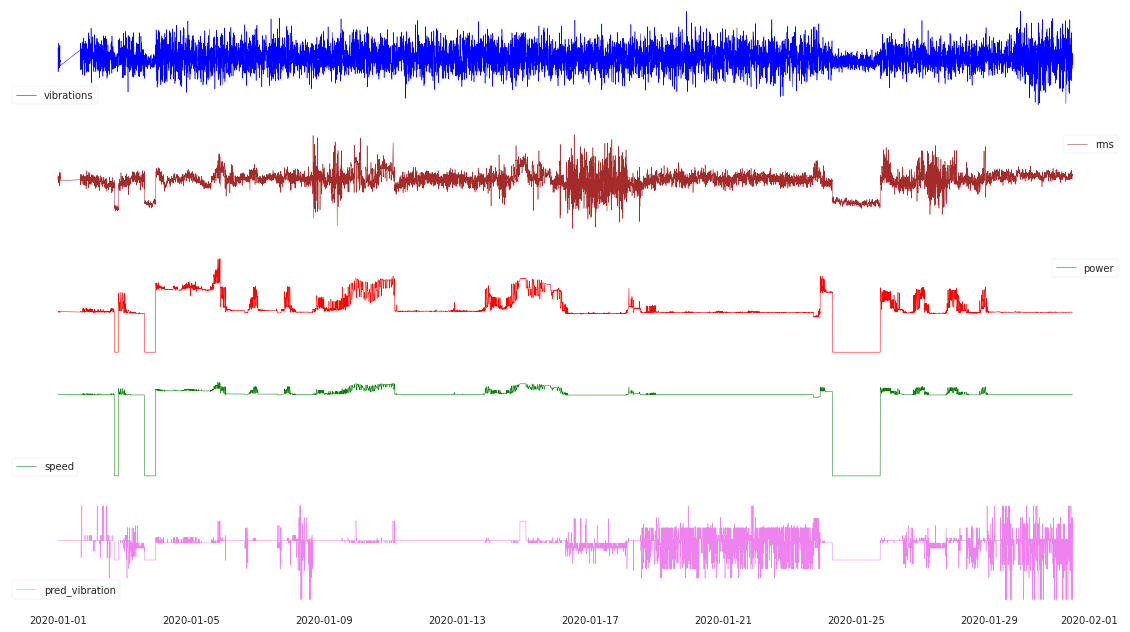

In [14]:
dfg = df_input.loc['04714B6046D5']

fig, ax = plt.subplots(5, 1,figsize=(20,11))

ax[0].plot(dfg.index, dfg['vibrations'], lw=0.5, color='blue', label='vibrations')
ax[1].plot(dfg.index, dfg['rms'], lw=0.5, color='brown', label='rms')
ax[2].plot(dfg.index, dfg['accel_power_0'], lw=0.5, color='red', label='power')
ax[3].plot(dfg.index, dfg['accel_speed'], lw=0.5, color='green', label='speed')
ax[4].plot(dfg.index, dfg['vib_pred'], lw=0.5, color='violet', label='pred_vibration')
[ax[i].legend() for i in range(5)]
[ax[i].set_xticks([]) for i in range(4)]
[ax[i].set_yticks([]) for i in range(5)]

In [15]:
modelName = 'model.TEST_ENTITY_FOR_GBMREGRESSOR.GBMRegressor.vibrations.04714B6046D5'
lgbm = gbmii.active_models[modelName][0].estimator['gbm']
valid_x = gbmii.active_models[modelName][1]

In [16]:
valid_x

vibrations       rms  accel_speed  \
entity       timestamp                                                    
04714B6046D5 2020-01-21 05:25:25.255    3.809259  2.171414  2316.566425   
             2020-01-11 23:43:10.858    3.745439  2.168019  2325.510697   
             2020-01-22 08:35:11.001    3.756354  2.171440  2316.566425   
             2020-01-30 23:14:20.996    3.746491  2.172817  2318.802493   
             2020-01-26 20:34:46.523    3.812139  2.166650  2343.399240   
...                                          ...       ...          ...   
             2020-01-06 22:02:44.139    3.734430  2.171600  2365.333169   
             2020-01-15 11:33:29.488    3.741701  2.170669  2432.841960   
             2020-01-06 17:37:43.103    3.777979  2.171688  2334.454969   
             2020-01-21 07:15:25.474    3.799278  2.170922  2316.566425   
             2020-01-07 00:37:44.826    3.778641  2.170703  2332.218901   

                                      accel_power_0  accel_power_1  \
entity       timestamp                                               
04714B6046D5 2020-01-21 05:25:25.255         2.2698         2.2742   
             2020-01-11 23:43:10.858         2.3362         2.3416   
             2020-01-22 08:35:11.001         2.2556         2.2570   
             2020-01-30 23:14:20.996         2.2650         2.2666   
             2020-01-26 20:34:46.523         2.5136         2.4778   
...                                             ...            ...   
             2020-01-06 22:02:44.139         2.6692         2.6380   
             2020-01-15 11:33:29.488         3.0216         3.0228   
             2020-01-06 17:37:43.103         2.4348         2.4098   
             2020-01-21 07:15:25.474         2.2616         2.2588   
             2020-01-07 00:37:44.826         2.4286         2.4362   

                                      accel_power_2  accel_power_3  \
entity       timestamp                                               
04714B6046D5 2020-01-21 05:25:25.255         2.2632         2.2624   
             2020-01-11 23:43:10.858         2.3406         2.3328   
             2020-01-22 08:35:11.001         2.2516         2.2554   
             2020-01-30 23:14:20.996         2.2632         2.2658   
             2020-01-26 20:34:46.523         2.5124         2.4674   
...                                             ...            ...   
             2020-01-06 22:02:44.139         2.6534         2.6590   
             2020-01-15 11:33:29.488         3.0242         3.0156   
             2020-01-06 17:37:43.103         2.3790         2.3990   
             2020-01-21 07:15:25.474         2.2630         2.2718   
             2020-01-07 00:37:44.826         2.4350         2.4278   

                                      accel_power_4 vib_pred  
entity       timestamp                                        
04714B6046D5 2020-01-21 05:25:25.255         2.2602     None  
             2020-01-11 23:43:10.858         2.3358     None  
             2020-01-22 08:35:11.001         2.2456     None  
             2020-01-30 23:14:20.996         2.2662     None  
             2020-01-26 20:34:46.523         2.5372     None  
...                                             ...      ...  
             2020-01-06 22:02:44.139         2.5072     None  
             2020-01-15 11:33:29.488         3.0102     None  
             2020-01-06 17:37:43.103         2.3740     None  
             2020-01-21 07:15:25.474         2.2728     None  
             2020-01-07 00:37:44.826         2.4270     None  

[6896 rows x 9 columns]

In [17]:

shap_values = shap.TreeExplainer(lgbm).shap_values(valid_x[features])


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


2020-05-28T19:00:15.839 DEBUG matplotlib.colorbar._get_ticker_locator_formatter locator: <matplotlib.ticker.FixedLocator object at 0x7f597fd43e50>
2020-05-28T19:00:15.839 DEBUG matplotlib.colorbar.update_ticks Using auto colorbar locator on colorbar
2020-05-28T19:00:15.840 DEBUG matplotlib.colorbar.update_ticks locator: <matplotlib.ticker.FixedLocator object at 0x7f597fd43e50>
2020-05-28T19:00:15.840 DEBUG matplotlib.colorbar._add_solids Setting pcolormesh
2020-05-28T19:00:15.842 DEBUG matplotlib.colorbar._get_ticker_locator_formatter locator: <matplotlib.ticker.FixedLocator object at 0x7f597fd43e50>
2020-05-28T19:00:15.843 DEBUG matplotlib.colorbar.update_ticks Using auto colorbar locator on colorbar
2020-05-28T19:00:15.843 DEBUG matplotlib.colorbar.update_ticks locator: <matplotlib.ticker.FixedLocator object at 0x7f597fd43e50>
2020-05-28T19:00:15.862 DEBUG matplotlib.font_manager._findfont_cached findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:

2020-05-28T19:00:15.885 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MathJax_Main' (MathJax_Main-Italic.otf) italic normal 400 normal>) = 11.05
2020-05-28T19:00:15.885 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Yrsa' (Yrsa-Light.ttf) normal normal light normal>) = 10.24
2020-05-28T19:00:15.886 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MathJax_AMS' (MathJax_AMS-Regular.otf) normal normal regular normal>) = 10.05
2020-05-28T19:00:15.886 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Kinnari' (Kinnari.ttf) normal normal 400 normal>) = 10.05
2020-05-28T19:00:15.886 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MathJax_SansSerif' (MathJax_SansSerif-Regular.otf) normal normal regular normal>) = 10.05
2020-05-28T19:00:15.887 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tlwg Typewriter' (TlwgTypewriter.ttf) normal normal 400 normal>) = 10.05
20

2020-05-28T19:00:15.919 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif CJK JP' (NotoSerifCJK-Regular.ttc) normal normal 400 normal>) = 10.05
2020-05-28T19:00:15.921 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Dyuthi' (Dyuthi-Regular.ttf) normal normal regular normal>) = 10.05
2020-05-28T19:00:15.921 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Mukti Narrow' (MuktiNarrow.ttf) normal normal 400 normal>) = 10.05
2020-05-28T19:00:15.922 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Bold.ttf) normal normal bold condensed>) = 10.535
2020-05-28T19:00:15.923 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Chilanka' (Chilanka-Regular.otf) normal normal regular normal>) = 10.05
2020-05-28T19:00:15.923 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Waree' (Waree-Oblique.ttf) oblique normal 400 normal

2020-05-28T19:00:15.954 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Ubuntu' (Ubuntu-MI.ttf) italic normal medium normal>) = 11.145
2020-05-28T19:00:15.954 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'KacstBook' (KacstBook.ttf) normal normal book normal>) = 10.05
2020-05-28T19:00:15.955 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Liberation Serif' (LiberationSerif-BoldItalic.ttf) italic normal bold normal>) = 11.335
2020-05-28T19:00:15.955 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Lohit Devanagari' (Lohit-Devanagari.ttf) normal normal 400 normal>) = 10.05
2020-05-28T19:00:15.956 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tlwg Typo' (TlwgTypo-Bold.ttf) normal normal bold normal>) = 10.335
2020-05-28T19:00:15.956 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Yrsa' (Yrsa-Medium.ttf) normal normal medium normal>) = 10.145
2020-05-28T19:0

2020-05-28T19:00:15.978 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Lohit Malayalam' (Lohit-Malayalam.ttf) normal normal 400 normal>) = 10.05
2020-05-28T19:00:15.979 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'KacstOne' (KacstOne-Bold.ttf) normal normal bold normal>) = 10.335
2020-05-28T19:00:15.979 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'mry_KacstQurn' (mry_KacstQurn.ttf) normal normal 400 normal>) = 10.05
2020-05-28T19:00:15.979 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Ubuntu' (Ubuntu-RI.ttf) italic normal 400 normal>) = 11.05
2020-05-28T19:00:15.980 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Lohit Tamil Classical' (Lohit-Tamil-Classical.ttf) normal normal 400 normal>) = 10.05
2020-05-28T19:00:15.980 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Norasi' (Norasi-BoldOblique.ttf) oblique normal bold normal>) = 11.335
2020-05-2

2020-05-28T19:00:16.003 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Lohit Assamese' (Lohit-Assamese.ttf) normal normal 400 normal>) = 10.05
2020-05-28T19:00:16.003 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'KacstFarsi' (KacstFarsi.ttf) normal normal 400 normal>) = 10.05
2020-05-28T19:00:16.003 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Lohit Bengali' (Lohit-Bengali.ttf) normal normal 400 normal>) = 10.05
2020-05-28T19:00:16.004 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Umpush' (Umpush-Oblique.ttf) oblique normal 400 normal>) = 11.05
2020-05-28T19:00:16.004 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Padauk' (Padauk-Bold.ttf) normal normal bold normal>) = 10.335
2020-05-28T19:00:16.005 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tlwg Mono' (TlwgMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
2020-05-28T19:00:16.005 DEBUG ma

2020-05-28T19:00:16.037 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal bold normal>) = 11.335
2020-05-28T19:00:16.038 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal bold normal>) = 10.335
2020-05-28T19:00:16.038 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
2020-05-28T19:00:16.039 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal bold normal>) = 10.335
2020-05-28T19:00:16.039 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 2.05
2020-05-28T19:00:16.039 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
20

2020-05-28T19:00:16.059 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'FreeMono' (FreeMonoBoldOblique.ttf) oblique normal bold normal>) = 11.335
2020-05-28T19:00:16.059 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MathJax_Vector' (MathJax_Vector-Regular.otf) normal normal regular normal>) = 10.05
2020-05-28T19:00:16.060 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Ubuntu' (Ubuntu-R.ttf) normal normal 400 normal>) = 10.05
2020-05-28T19:00:16.060 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Purisa' (Purisa.ttf) normal normal 400 normal>) = 10.05
2020-05-28T19:00:16.061 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MathJax_Size3' (MathJax_Size3-Regular.otf) normal normal regular normal>) = 10.05
2020-05-28T19:00:16.061 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Liberation Sans' (LiberationSans-Bold.ttf) normal normal bold normal>) = 4.335
202

2020-05-28T19:00:16.080 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Liberation Mono' (LiberationMono-Italic.ttf) italic normal 400 normal>) = 11.05
2020-05-28T19:00:16.081 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Liberation Sans' (LiberationSans-Regular.ttf) normal normal 400 normal>) = 4.05
2020-05-28T19:00:16.082 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Ubuntu Condensed' (Ubuntu-C.ttf) normal normal 400 condensed>) = 10.25
2020-05-28T19:00:16.083 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tlwg Typist' (TlwgTypist-Oblique.ttf) oblique normal 400 normal>) = 11.05
2020-05-28T19:00:16.083 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Rasa' (Rasa-SemiBold.ttf) normal normal semibold normal>) = 10.24
2020-05-28T19:00:16.083 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Sarai' (Sarai.ttf) normal normal 400 normal>) = 10.05
2020-05-28T

2020-05-28T19:00:16.104 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Liberation Serif' (LiberationSerif-Regular.ttf) normal normal 400 normal>) = 10.05
2020-05-28T19:00:16.104 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tibetan Machine Uni' (TibetanMachineUni.ttf) normal normal 400 normal>) = 10.05
2020-05-28T19:00:16.105 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Ubuntu Mono' (UbuntuMono-B.ttf) normal normal bold normal>) = 10.335
2020-05-28T19:00:16.105 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Sawasdee' (Sawasdee-BoldOblique.ttf) oblique normal bold normal>) = 11.335
2020-05-28T19:00:16.106 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tlwg Typewriter' (TlwgTypewriter-Bold.ttf) normal normal bold normal>) = 10.335
2020-05-28T19:00:16.106 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Sans CJK JP' (NotoSansCJK-Bold.ttc) normal n

2020-05-28T19:00:16.129 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Loma' (Loma-Oblique.ttf) oblique normal 400 normal>) = 11.05
2020-05-28T19:00:16.130 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Umpush' (Umpush-Bold.ttf) normal normal bold normal>) = 10.335
2020-05-28T19:00:16.130 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MathJax_Size4' (MathJax_Size4-Regular.otf) normal normal regular normal>) = 10.05
2020-05-28T19:00:16.131 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'KacstTitle' (KacstTitle.ttf) normal normal 400 normal>) = 10.05
2020-05-28T19:00:16.132 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MathJax_Caligraphic' (MathJax_Caligraphic-Regular.otf) normal normal regular normal>) = 10.05
2020-05-28T19:00:16.133 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Rachana' (Rachana-Bold.ttf) normal normal bold normal>) = 10.335
2020-05

2020-05-28T19:00:16.179 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal regular normal>) = 10.05
2020-05-28T19:00:16.180 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
2020-05-28T19:00:16.180 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 3.05
2020-05-28T19:00:16.181 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal bold normal>) = 11.335
2020-05-28T19:00:16.181 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05
2020-05-28T19:00:16.206 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 10.05

2020-05-28T19:00:16.226 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Garuda' (Garuda-BoldOblique.ttf) oblique normal bold normal>) = 11.335
2020-05-28T19:00:16.226 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Ani' (ani.ttf) normal normal 400 normal>) = 10.05
2020-05-28T19:00:16.227 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'FreeSerif' (FreeSerif.ttf) normal normal 400 normal>) = 10.05
2020-05-28T19:00:16.227 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Sawasdee' (Sawasdee-Oblique.ttf) oblique normal 400 normal>) = 11.05
2020-05-28T19:00:16.227 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Khmer OS System' (KhmerOSsys.ttf) normal normal 400 normal>) = 10.05
2020-05-28T19:00:16.228 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Uroob' (Uroob-Regular.ttf) normal normal regular normal>) = 10.05
2020-05-28T19:00:16.228 DEBUG matplotlib.font_man

2020-05-28T19:00:16.251 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MathJax_Main' (MathJax_Main-Bold.otf) normal normal bold normal>) = 10.335
2020-05-28T19:00:16.252 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Liberation Mono' (LiberationMono-BoldItalic.ttf) italic normal bold normal>) = 11.335
2020-05-28T19:00:16.253 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'GLYPHICONS Halflings' (glyphicons-halflings-regular.ttf) normal normal regular normal>) = 10.05
2020-05-28T19:00:16.253 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Ubuntu' (Ubuntu-B.ttf) normal normal bold normal>) = 10.335
2020-05-28T19:00:16.253 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MathJax_Fraktur' (MathJax_Fraktur-Bold.otf) normal normal bold normal>) = 10.335
2020-05-28T19:00:16.259 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'LKLUG' (lklug.ttf) normal normal 400 n

2020-05-28T19:00:16.327 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Manjari' (Manjari-Bold.otf) normal normal bold normal>) = 10.335
2020-05-28T19:00:16.327 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'MathJax_Math' (MathJax_Math-Italic.otf) italic normal 400 normal>) = 11.05
2020-05-28T19:00:16.328 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Garuda' (Garuda-Bold.ttf) normal normal bold normal>) = 10.335
2020-05-28T19:00:16.329 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Samanata' (samanata.ttf) normal normal 400 normal>) = 10.05
2020-05-28T19:00:16.329 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Tlwg Mono' (TlwgMono-Bold.ttf) normal normal bold normal>) = 10.335
2020-05-28T19:00:16.330 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'FreeSerif' (FreeSerifBoldItalic.ttf) italic normal bold normal>) = 11.335
2020-05-28T19:00:16.331 DEBUG m

2020-05-28T19:00:16.367 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Rasa' (Rasa-Medium.ttf) normal normal medium normal>) = 10.145
2020-05-28T19:00:16.367 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'FreeSerif' (FreeSerifItalic.ttf) italic normal 400 normal>) = 11.05
2020-05-28T19:00:16.368 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Ubuntu Mono' (UbuntuMono-R.ttf) normal normal 400 normal>) = 10.05
2020-05-28T19:00:16.369 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Noto Serif CJK JP' (NotoSerifCJK-Bold.ttc) normal normal bold normal>) = 10.335
2020-05-28T19:00:16.369 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Rasa' (Rasa-Light.ttf) normal normal light normal>) = 10.24
2020-05-28T19:00:16.369 DEBUG matplotlib.font_manager._findfont_cached findfont: score(<Font 'Ubuntu' (Ubuntu-L.ttf) normal normal light normal>) = 10.24
2020-05-28T19:00:16.370 DEBUG matplotl

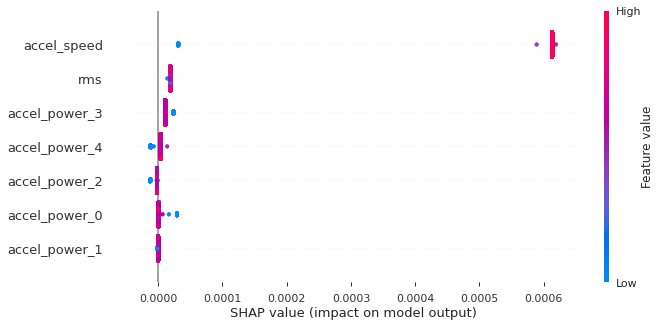

In [18]:
shap.summary_plot(shap_values, valid_x[features], plot_size=(10,5))


2020-05-28T19:00:16.928 DEBUG matplotlib.colorbar._get_ticker_locator_formatter locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f597ff959d0>
2020-05-28T19:00:16.929 DEBUG matplotlib.colorbar.update_ticks Using auto colorbar locator on colorbar
2020-05-28T19:00:16.931 DEBUG matplotlib.colorbar.update_ticks locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f597ff959d0>
2020-05-28T19:00:16.931 DEBUG matplotlib.colorbar._add_solids Setting pcolormesh


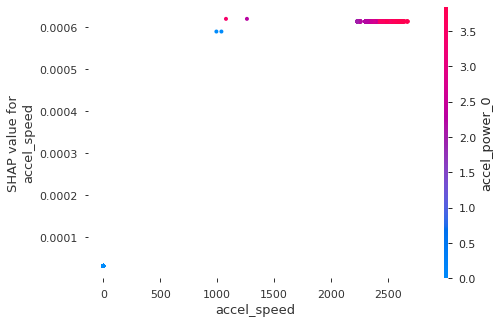

In [19]:
shap.dependence_plot("accel_speed", shap_values, valid_x[features])

In [21]:
#shap.force_plot("accel_power_1", shap_values, valid_x[['accel_power_0','accel_power_1']])
shap.initjs()
test_x = valid_x[features]

test_sample = test_x.iloc[:1000,:]
shap_values_sample = shap.TreeExplainer(lgbm).shap_values(test_sample)
shap.force_plot(shap.TreeExplainer(lgbm).expected_value, shap_values_sample, test_sample,
                link="identity", figsize=(10,4))

In [55]:
print (gbmii._entity_type.db.model_store)

In [12]:
gbmii = GBMRegressor(features=['accel_power_0','accel_power_1'], max_depth=20, num_leaves=40,
                     n_estimators=4000, learning_rate=0.00001, targets=['rms'],
                     predictions=['rms_pred'])
gbmii.correlation_threshold = 0.001

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}
et = gbmii._build_entity_type(columns = [Column('accel_power_0',Float()), Column('accel_power_1',Float()),
                                        Column('vibrations',Float())], **jobsettings)
gbmii._entity_type = et

# disallow training and preserve existing models for predict
gbmii.auto_train = False
gbmii.delete_existing_models = False
df_input = gbmii.execute(df=df_input)

2020-03-30T17:38:30.568 DEBUG iotfunctions.metadata.__init__ Initializing new entity type using iotfunctions 2.0.3
2020-03-30T17:38:30.569 DEBUG iotfunctions.util.__init__ Starting trace
2020-03-30T17:38:30.570 DEBUG iotfunctions.util.__init__ Trace name: auto_trace_test_entity_for_GBMRegressor_20200330153830
2020-03-30T17:38:30.570 DEBUG iotfunctions.util.__init__ auto_save None
2020-03-30T17:38:30.571 DEBUG iotfunctions.util.categorize_args categorizing arguments
2020-03-30T17:38:30.572 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-03-30T17:38:30.573 DEBUG iotfunctions.metadata.__init__ Initialized entity type 
LocalEntityType:TEST_ENTITY_FOR_GBMREGRESSOR
Functions:
Granularities:
No schedules metadata
2020-03-30T17:38:30.575 DEBUG mmfunctions.anomaly.execute ['04714B6046D5' 'testentity']
2020-03-30T17:38:30.579 INFO iotfunctions.base.get_models_for_training predic

In [15]:
# Run Monitoring's anomaly detector functions
# EngineLogging.configure_console_logging(logging.DEBUG)

simpleii = SimpleRegressor(features=['accel_power_0','accel_power_1'], # max_depth=20, num_leaves=40,
                     n_estimators=4000, learning_rate=0.00001, targets=['rms'],
                     predictions=['rms_pred'])
simpleii.correlation_threshold = 0.001

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}
et = simpleii._build_entity_type(columns = [Column('accel_power_0',Float()), Column('accel_power_1',Float()),
                                            Column('vibrations',Float())], **jobsettings)
simpleii._entity_type = et

# allow training and delete existing models
simpleii.auto_train = True
simpleii.delete_existing_models = True
df_input = simpleii.execute(df=df_input)

2020-03-30T19:17:29.485 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-03-30T19:17:29.494 INFO iotfunctions.base.delete_models Model names to delete: ['model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.04714B6046D5']
2020-03-30T19:17:29.981 INFO iotfunctions.dbtables.delete_model Model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.04714B6046D5 has been deleted from table "BLUADMIN"."KPI_MODEL_STORE"
2020-03-30T19:17:29.984 INFO iotfunctions.base.get_models_for_training predicting target rms
2020-03-30T19:17:30.782 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.04714B6046D5 does not exist in table "BLUADMIN"."KPI_MODEL_STORE"
2020-03-30T19:17:30.783 INFO iotfunctions.base.get_models_for_training load model None
2020-03-30T19:17:30.784 INFO iotfunctions.base.get_models_for_training training r

/home/markus/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


2020-03-30T19:17:34.760 INFO iotfunctions.dbtables.store_model Model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.04714B6046D5 of size 3725 bytes has been stored in table "BLUADMIN"."KPI_MODEL_STORE".
2020-03-30T19:17:34.761 INFO iotfunctions.base._execute Finished training model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.04714B6046D5
2020-03-30T19:17:35.555 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.04714B6046D5 of size 3725 bytes has been retrieved from table "BLUADMIN"."KPI_MODEL_STORE"
2020-03-30T19:17:35.558 INFO iotfunctions.metadata.predict predicted using model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.04714B6046D5
Index(['vibrations', 'rms', 'accel_speed', 'accel_power_0', 'accel_power_1',
       'accel_power_2', 'accel_power_3', 'accel_power_4', 'rms_pred'],
      dtype='object')
Index(['vibrations', 'rms', 'accel_speed', 'accel_power_0', 'accel_power_1',
       'accel_p

/home/markus/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


2020-03-30T19:17:42.701 INFO iotfunctions.base.find_best_model Trained model no: 0
2020-03-30T19:17:42.748 INFO iotfunctions.base.find_best_model Trained model no: 0 score:0.5410548785172714
2020-03-30T19:17:42.762 INFO iotfunctions.metadata.test evaluated model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.testentity with evaluation metric value 0.4745025856970637
2020-03-30T19:17:42.775 INFO iotfunctions.metadata.test evaluated model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.testentity with evaluation metric value 0.4745025856970637
2020-03-30T19:17:47.517 INFO iotfunctions.dbtables.store_model Model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.testentity of size 928905 bytes has been stored in table "BLUADMIN"."KPI_MODEL_STORE".
2020-03-30T19:17:47.518 INFO iotfunctions.base._execute Finished training model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.testentity
2020-03-30T19:17:58.372 INFO iotfunctions.dbtables.retrieve_model Mo

In [16]:

simpleii = SimpleRegressor(features=['accel_power_0','accel_power_1'], # max_depth=20, num_leaves=40,
                     n_estimators=4000, learning_rate=0.00001, targets=['rms'],
                     predictions=['rms_pred'])
simpleii.correlation_threshold = 0.001

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}
et = simpleii._build_entity_type(columns = [Column('accel_power_0',Float()), Column('accel_power_1',Float()),
                                            Column('vibrations',Float())], **jobsettings)
simpleii._entity_type = et

# disallow training and preserve existing models for predict
simpleii.auto_train = False
simpleii.delete_existing_models = False
df_input = simpleii.execute(df=df_input)


2020-03-30T19:21:16.718 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-03-30T19:21:16.722 INFO iotfunctions.base.get_models_for_training predicting target rms
2020-03-30T19:21:17.523 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.04714B6046D5 of size 3725 bytes has been retrieved from table "BLUADMIN"."KPI_MODEL_STORE"
2020-03-30T19:21:17.525 INFO iotfunctions.base.get_models_for_training load model {
 "name": "model.TEST_ENTITY_FOR_SIMPLEREGRESSOR.SimpleRegressor.rms.04714B6046D5",
 "target": "rms",
 "features": [
  "accel_power_0",
  "accel_power_1"
 ],
 "estimator_name": "sgd_regressor",
 "eval_metric_name": "r2_score",
 "eval_metric_train": -1.0187012829267998,
 "eval_metric_test": -1.0230987986948104,
 "trained_date": "2020-03-30T17:17:34.254244",
 "expiry_date": null
}
2020-03-30T19:21:17.525 INFO iotfun